![](https://www.gstatic.com/devrel-devsite/v2355ed73ae6b243a36832e70498f2cd0b3f352ff30481ebdfdc56826b566bf8a/tensorflow/images/lockup.svg)

До сегодняшнего дня мы собирали различные довольно простые модели в высокоуровневом API для [tensorflow](https://www.tensorflow.org/) под названием Keras. Сегодня, наконец, пришло время поиграться с голым 
 функционалом библиотеки и посмотреть, как в нём собираются и обучаются самые простые модели. 

In [ ]:
import numpy as np

In [ ]:
import tensorflow as tf
tf.__version__

'2.5.0'

# 0. Tensoflow teaser





Давайте реализуем на `numpy` и на `tensorflow` функцию для поиска суммы квадратов первых $N$ чисел и посмотрим насколько быстро эти функции работают.

Но давайте еще сравним скорость выполнения с простым питоном.

In [ ]:
def python_sum_squares(N):
    return sum([val ** 2 for val in range(N)])

In [ ]:
def np_sum_squares(N):
    return np.sum(np.arange(N)**2)

In [ ]:
N = 10**8

Будет долго..почему так, у кого какие идеи?

In [ ]:
%time python_sum_squares(N)

CPU times: user 32.2 s, sys: 1.67 s, total: 33.9 s
Wall time: 33.9 s


333333328333333350000000

In [ ]:
%timeit np_sum_squares(N)

1 loop, best of 5: 340 ms per loop


Tensorflow из-за того, что мы сначала задаём структуру вычислений, а после осуществляем их работает не сильно быстрее или даже медленнее, чем numpy.

In [ ]:
def tf_sum_squares(N):
    N = tf.constant(N, dtype='int64')
    return tf.reduce_sum((tf.range(N)**2))

In [ ]:
%%timeit
tf_sum_squares(N)

1 loop, best of 5: 319 ms per loop


Более того, когда вы уже задали свой граф вычислений и убедились, что всё работает, можно вызвать декоратор `tf.function`. [Он сделает работу заданного графа](https://www.tensorflow.org/tutorials/customization/performance) более оптимальной и ещё ускорит код. 

In [ ]:
@tf.function
def tf_sum_squares(N):
    N = tf.constant(N, dtype='int64')
    return tf.reduce_sum((tf.range(N)**2))

In [ ]:
%%timeit
tf_sum_squares(N)

The slowest run took 35.48 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 237 µs per loop


Если сравнивать время, то мы видим значительный прогресс в скорости вычислений даже для простой задачи. Данный прирост будет значительно большим для сложных и тяжелых по памяти рассчетов.
Однако стоит помнить, что в таких случая первый запуск всегда будет дольше, надо "прогреть" кэш.

# 1. Тензоры и базовые операции над ними

Основной объект в tensorflow - это **тензор.** Или многомерный массив чисел. Чтобы не нужно было учить кучу новых команд, tensorflow косплеит numpy. 

```
    np.zeros -> tf.zeros
    np.sin -> tf.sin
    np.mean -> tf.reduce_mean
    np.arange -> tf.range
    np.cumsum -> tf.cumsum
```

Правда говоря, не совсем косплеит. Но чаще всего оказываетс довольно близок.

In [ ]:
# можно задать тензор из нулей
tf.zeros([3, 4])

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

In [ ]:
# или из единиц, но уже более сложной размерности
tf.ones([3, 4, 2])

<tf.Tensor: shape=(3, 4, 2), dtype=float32, numpy=
array([[[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]],

       [[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]]], dtype=float32)>

In [ ]:
# так можно сгенерировать диагональную матрицу
tf.eye(3)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)>

In [ ]:
# так можно сгенерировать диагональную матрицу кастомной размерности
tf.eye(3, 2)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 0.],
       [0., 1.],
       [0., 0.]], dtype=float32)>

In [ ]:
#генерируем числа от 1 до 4. Не итератор, сразу все отдает в память!
tf.range(1, 5, 1)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([1, 2, 3, 4], dtype=int32)>

In [ ]:
#транспонирование
tf.transpose(tf.eye(3, 2))


<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 1., 0.]], dtype=float32)>

In [ ]:
# можно сгенерировать тензор из нормального распределения
tf.random.normal([2,2])

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-1.9435283 ,  0.43159175],
       [ 0.08983134,  0.04324746]], dtype=float32)>

In [ ]:
# можно просто сделать залифку тензора какими-то числами
tf.fill([2, 2], 0.5)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.5, 0.5],
       [0.5, 0.5]], dtype=float32)>

In [ ]:
# можно создать матрицу в numpy
x = np.array([[1, 2, 3, 4],
              [4, 3, 2, 1]])
x

array([[1, 2, 3, 4],
       [4, 3, 2, 1]])

In [ ]:
# а потом перевести её в тензор
tf.convert_to_tensor(x, tf.float32) 

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[1., 2., 3., 4.],
       [4., 3., 2., 1.]], dtype=float32)>

In [ ]:
# или можно просто сразу создать тензор 
tf.constant([[1,  2,  3,  4],
             [5,  6,  7,  8],
             [9, 10, 11, 12]])

<tf.Tensor: shape=(3, 4), dtype=int32, numpy=
array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]], dtype=int32)>

In [ ]:
# наверное, стоит уточнить тип данных в тензоре
x = tf.constant([[1,  2,  3,  4],
                 [5,  6,  7,  8],
                 [9, 10, 11, 12]], dtype=tf.float32)

Все срезы, операции, размерности работают как в numpy.

In [ ]:
x.dtype

tf.float32

In [ ]:
x.shape

TensorShape([3, 4])

In [ ]:
x[0]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1., 2., 3., 4.], dtype=float32)>

In [ ]:
x[:,1]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 2.,  6., 10.], dtype=float32)>

In [ ]:
x + 10

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[11., 12., 13., 14.],
       [15., 16., 17., 18.],
       [19., 20., 21., 22.]], dtype=float32)>

In [ ]:
x[x > 3]

<tf.Tensor: shape=(9,), dtype=float32, numpy=array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.], dtype=float32)>

In [ ]:
y = tf.constant([[12, 11, 10, 9],
                  [8, 7, 6, 5],
                  [4, 3, 2, 1]], dtype=tf.float32)

In [ ]:
x + y

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[13., 13., 13., 13.],
       [13., 13., 13., 13.],
       [13., 13., 13., 13.]], dtype=float32)>

In [ ]:
x**y

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[1.0000000e+00, 2.0480000e+03, 5.9049008e+04, 2.6214400e+05],
       [3.9062500e+05, 2.7993597e+05, 1.1764900e+05, 3.2768000e+04],
       [6.5610000e+03, 1.0000000e+03, 1.2100000e+02, 1.2000000e+01]],
      dtype=float32)>

In [ ]:
tf.math.exp(x)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[2.7182817e+00, 7.3890562e+00, 2.0085537e+01, 5.4598148e+01],
       [1.4841316e+02, 4.0342877e+02, 1.0966332e+03, 2.9809580e+03],
       [8.1030840e+03, 2.2026465e+04, 5.9874141e+04, 1.6275480e+05]],
      dtype=float32)>

In [ ]:
tf.matmul(x, y, transpose_b=True)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[100.,  60.,  20.],
       [268., 164.,  60.],
       [436., 268., 100.]], dtype=float32)>

In [ ]:
x

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6.,  7.,  8.],
       [ 9., 10., 11., 12.]], dtype=float32)>

In [ ]:
tf.reshape(x, [4, 3])

<tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[ 1.,  2.,  3.],
       [ 4.,  5.,  6.],
       [ 7.,  8.,  9.],
       [10., 11., 12.]], dtype=float32)>

In [ ]:
tf.reshape(x, [2, 2, 3])

<tf.Tensor: shape=(2, 2, 3), dtype=float32, numpy=
array([[[ 1.,  2.,  3.],
        [ 4.,  5.,  6.]],

       [[ 7.,  8.,  9.],
        [10., 11., 12.]]], dtype=float32)>

In [ ]:
# Когда надоело работать с тензором, можно вернуться назад в numpy формат
x.numpy() 

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6.,  7.,  8.],
       [ 9., 10., 11., 12.]], dtype=float32)

In [ ]:
# тип у тензоров может быть разный, но всегда один
tf.constant("hello world")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

Попробуем реализовать на tensorflow сигмоиду. 

$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

In [ ]:
x = tf.linspace(-1.,1.,10)
sigmoid = 1./(1+tf.exp(-x))

sigmoid

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.26894143, 0.314799  , 0.36457646, 0.41742983, 0.47225076,
       0.52774924, 0.5825702 , 0.6354236 , 0.685201  , 0.7310586 ],
      dtype=float32)>

Попробуем реализовать на tensorflow среднюю квадратичную ошибку. 

$$ 
MSE(\hat y, y) = \frac{1}{n} \sum_{i=1}^n (\hat y - y)^2
$$

In [ ]:
y_true = tf.constant([1.,2.,3.,4.,5.],tf.float32)
y_pred = tf.constant([10.,20.,30.,40.,50.],tf.float32)
diff = y_true-y_pred
mse = tf.reduce_mean(tf.pow(diff,2))

mse

<tf.Tensor: shape=(), dtype=float32, numpy=891.0>

------------------------------------------

# 2. Производные да градиенты

Тензорфлоу может вычислять производные и градиенты автоматически. Для этого используется [`GradientTape.`](https://www.tensorflow.org/tutorials/customization/autodiff)

Он проходит по всем операциям, которые фигурируют в графе, и применяет к ним chain rule:

$$ {\partial f(g(x)) \over \partial x} = {\partial f(g(x)) \over \partial g(x)}\cdot {\partial g(x) \over \partial x} $$

Мы можем посчитать производную по любому тензору, участвующему в вычислениях.

In [ ]:
x = tf.constant([0.3, 1])

# опция persistent=True позволяет искать производную много раз, а не один
with tf.GradientTape(persistent=True) as t:
    t.watch(x)
    y = tf.reduce_sum(x)
    z = y**2

In [ ]:
t.gradient(z, x)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.6, 2.6], dtype=float32)>

In [ ]:
t.gradient(z, y)

<tf.Tensor: shape=(), dtype=float32, numpy=2.6>

Нарисуем функцию и её производную на картинке :) 

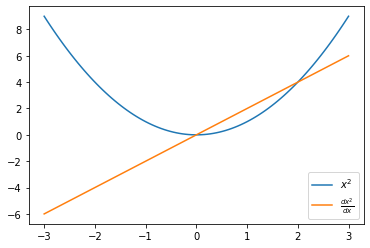

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

x = tf.linspace(-3., 3., 100)

with tf.GradientTape(persistent=True) as t:
    t.watch(x)
    y = x**2

dy_dx = t.gradient(y, x)

plt.plot(x, y, label="$x^2$")
plt.plot(x, dy_dx, label=r"$\frac{dx^2}{dx}$")
plt.legend();


Реализуем расчёт градиента для функции 

$$
f(w) = \prod_{i,j} \ln(\ln(w_{ij} + 7) 
$$

в точке `w = [[5,10], [1,2]]`

In [ ]:
w = tf.constant([[5,10], [1,2]], dtype=tf.float32)

with tf.GradientTape() as t:
    t.watch(w)
    f = tf.reduce_prod(tf.math.log(tf.math.log(w+tf.constant(7.,tf.float32))))

df_dw = t.gradient(f,w)

df_dw

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.0201272 , 0.01089125],
       [0.04485611, 0.03509369]], dtype=float32)>

# 3. Переменные

Следущий важный объект в tensorflow это **переменная.** Она представляет из себя некоторый буфер в памяти, который содержит текущие тензоры. 

* Переменную можно вставить в любое место графа 
* Переменные можно использовать, чтобы описать какую-то трансформацию
* В процессе расчётов их можно изменять
* Обычно их исползуют для описания параметров модели

In [ ]:
w = tf.Variable(initial_value=0.5)
w

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5>

In [ ]:
x = np.array([1,2,3], dtype=float)
x

array([1., 2., 3.])

In [ ]:
x*w

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.5, 1. , 1.5], dtype=float32)>

Более того, переменные хороши тем, что Tensorflow сразу же следит за ними при вычислении производных. Ему не надо указывать с помощью команды `watch`, за каким тензором нужно приглядывать. 

Реализуем расчёт градиента для функции 

$$
f(w) = \prod_{i,j} \ln(\ln(w_{ij} + 7) 
$$

в точке `w = [[5,10], [1,2]]`. Отличие от предыдущей задачки такое: надо задать $w$ не как тензор, а как переменную. 

In [ ]:
w = tf.Variable(initial_value=[[5.,10], [1,2]])
with tf.GradientTape() as t:
    f = tf.reduce_prod(tf.math.log(tf.math.log(w+tf.constant(7.,tf.float32))))

df_dw = t.gradient(f,w)

df_dw

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.0201272 , 0.01089125],
       [0.04485611, 0.03509369]], dtype=float32)>

------------------------------------------

# 4. Оптимизация

Итак, tf умеет искать производные, осталось научиться применять его для оптимизации. 

Попробуем решить глупую задачку по конвертации градусов по цельсию в градусы по фаренгейту. По данным будем пытаться восстановить формулу: 

$$ f = c \times 1.8 + 32 $$

In [ ]:
celsius    = np.array([-40, -10,  0,  8, 15, 22,  38],  dtype='float32')
fahrenheit = np.array([-40,  14, 32, 46, 59, 72, 100],  dtype='float32')

for i,c in enumerate(celsius):
    print("{} degrees Celsius = {} degrees Fahrenheit".format(c, fahrenheit[i]))

-40.0 degrees Celsius = -40.0 degrees Fahrenheit
-10.0 degrees Celsius = 14.0 degrees Fahrenheit
0.0 degrees Celsius = 32.0 degrees Fahrenheit
8.0 degrees Celsius = 46.0 degrees Fahrenheit
15.0 degrees Celsius = 59.0 degrees Fahrenheit
22.0 degrees Celsius = 72.0 degrees Fahrenheit
38.0 degrees Celsius = 100.0 degrees Fahrenheit


In [ ]:
# параметры модели 
a = tf.Variable(tf.random.normal([1]), name='bias')
b = tf.Variable(tf.random.normal([1]), name='k')

a.numpy(), b.numpy()

(array([-0.23020725], dtype=float32), array([-2.0108762], dtype=float32))

In [ ]:
# Наша модель
def linear_regression(x):
    return a + b*x

# Ошибка для модели
def mean_square(y_pred, y_true):
    return tf.reduce_mean((y_pred-y_true)**2)

In [ ]:
linear_regression(celsius).numpy()

array([ 80.204834  ,  19.878553  ,  -0.23020725, -16.317217  ,
       -30.39335   , -44.469482  , -76.6435    ], dtype=float32)

In [ ]:
mean_square(linear_regression(celsius), fahrenheit).numpy()

10309.317

In [ ]:
# оптимизатор 
optimizer = tf.optimizers.SGD(learning_rate=0.001)

# процесс оптимизации
def model_train(X, Y):

    # находим loss и пробрасываем градиент
    with tf.GradientTape() as g:
        pred = linear_regression(X)
        loss = mean_square(pred, Y)

    # Вычисляем градиенты
    gradients = g.gradient(loss, [a, b])
    
    # Обновляем веса a и b в ходе одной итерации спуска 
    optimizer.apply_gradients(zip(gradients, [a, b]))
    pass

In [ ]:
a

<tf.Variable 'bias:0' shape=(1,) dtype=float32, numpy=array([-0.23020725], dtype=float32)>

In [ ]:
model_train(celsius, fahrenheit)

In [ ]:
print(f'bias = {a.numpy()[0]: .2f}, k = {b.numpy()[0]: .2f}')

bias = -0.13, k =  2.56


In [ ]:
# Обучение
epochs = 2000 # число эпох 

for i in range(epochs):
    
    # Делаем щаг градиентного спуска 
    model_train(celsius, fahrenheit)
    
    # Каждую сотую итерацию следим за тем, что произошло
    if i%100 == 0:
        y_pred = linear_regression(celsius)
        loss_val = mean_square(y_pred, fahrenheit)
        print("step: %i, loss: %f, a: %f, b: %f" % (i, loss_val, a.numpy(), b.numpy()))

step: 0, loss: 986.808716, a: -0.072905, b: 2.010222
step: 100, loss: 670.579102, a: 5.528138, b: 2.020952
step: 200, loss: 456.564697, a: 10.149262, b: 1.981953
step: 300, loss: 310.858887, a: 13.962246, b: 1.949774
step: 400, loss: 211.659546, a: 17.108402, b: 1.923223
step: 500, loss: 144.122604, a: 19.704350, b: 1.901315
step: 600, loss: 98.141724, a: 21.846331, b: 1.883238
step: 700, loss: 66.837242, a: 23.613705, b: 1.868323
step: 800, loss: 45.524239, a: 25.072014, b: 1.856016
step: 900, loss: 31.013948, a: 26.275290, b: 1.845861
step: 1000, loss: 21.135107, a: 27.268126, b: 1.837482
step: 1100, loss: 14.409338, a: 28.087343, b: 1.830568
step: 1200, loss: 9.830279, a: 28.763292, b: 1.824864
step: 1300, loss: 6.712808, a: 29.321026, b: 1.820157
step: 1400, loss: 4.590368, a: 29.781219, b: 1.816273
step: 1500, loss: 3.145320, a: 30.160946, b: 1.813069
step: 1600, loss: 2.161501, a: 30.474268, b: 1.810425
step: 1700, loss: 1.491699, a: 30.732796, b: 1.808243
step: 1800, loss: 1.035

In [ ]:
print(f'bias = {a.numpy()[0]: .2f}, k = {b.numpy()[0]: .2f}')

bias =  31.27, k =  1.80


Можно сделать то же самое, но с визуализацией. 

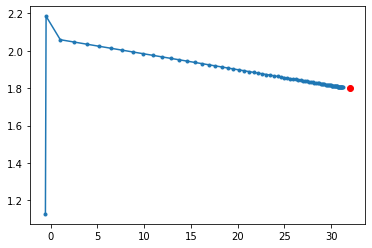

In [ ]:
from IPython.display import clear_output

epochs = 2000 # число эпох 

a = tf.Variable(tf.random.normal([1]), name='bias')
b = tf.Variable(tf.random.normal([1]), name='k')


ass = [a.numpy()[0]] # стартовые точки 
bss = [b.numpy()[0]] 

for i in range(epochs):
    # Делаем щаг градиентного спуска 
    model_train(celsius, fahrenheit)
    
    if i%25 == 0:
        # Пополняем запас точек 
        ass.append(a.numpy()[0])
        bss.append(b.numpy()[0])

        clear_output(True) # чтобы всё на одной картинке рисовалось, а не на милионе
        plt.plot(ass, bss, marker='.')
        plt.scatter(32, 1.8, c='red')
        plt.show()

------------------------------------------

Можно попробовать поразвлекаться с разными методами оптимизации! 

* На вход модели при обучении мы сейчас подавали нумпаевские вектора. В будущем мы будем смотреть и на разные другие способы скармливать модели данные.

# 5. Нейронка на Tensorflow 

Пришло время страдать. Чтобы пострадать как следует, вы получаете задание --- построить свою первую нейросеть в tensorflow. __Спойлер:__ cильнее вего вы будете страдать от того, что размерности матриц не сходятся. Осторожнее с этим. 

Раньше все учили свою первую нейросеть на [наборе рукопистных цифр MNIST.](http://yann.lecun.com/exdb/mnist/) Теперь это не модно. Если где-то кто-то будет проводить у вас семинар с участием этого датасета, так и скажите ему: __это не модно!__  Хлопать дверью или нет --- на ваше усмотрение. 

На арене туториалов новый король: [Fashion MNIST.](https://www.tensorflow.org/tutorials/keras/classification) По ссылке лежит туториал с строительством нейросетки на этом наборе, но с участием Keras. Мы пока что обойдёмся без него.

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [ ]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Нарисуем несколько рандомных картинок из тренировочной выборки. 

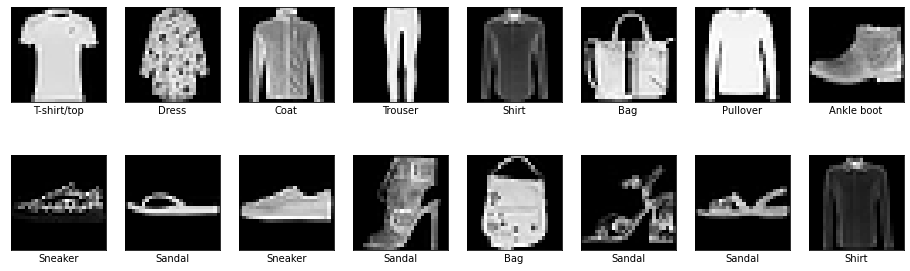

In [ ]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(X_train[random_index, :], cmap = 'gray')
        ax.set_xlabel(class_names[y_train[random_index]])
plt.show()

Каждая картинка это матрица из чисел. Если число большое - пиксель яркий. Если маленькое - тёмный. Яркость измеряется по шкале от $0$ до $255$.

In [ ]:
X_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

Картинка - матрица. 

In [ ]:
X_train[0].shape

(28, 28)

Давайте отнормируем выборку. 

In [ ]:
X_train = X_train/255
X_test = X_test/255

Будем прогнозировать тип картинки по её пикселям. Давайте растянем её в вектор из $28 \times 28$ фичей.

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28**2)
X_test = X_test.reshape(X_test.shape[0], 28**2)
X_train.shape

(60000, 784)

Поставим для данных тип, чтобы ничего не поломалось.

In [ ]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

У нас в задаче фигурирует $10$ классов. Последним слоем в сетке будет Softmax. Не забудьте сделать OHE, когда будете описывать функцию потерь. 

In [ ]:
tf.keras.utils.to_categorical(y_train)

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

## Приступим...

Для начала обучим однослойною модель. Задайте её архитектуру и напишите функцию для прогнозирования. 

In [ ]:
num_classes = 10   # число классов
num_features = 784 # число фичей (28*28 пикселей)

W = tf.Variable(tf.random.normal([num_features,num_classes]),tf.float32)
b = tf.Variable(tf.random.normal([num_classes]),tf.float32)


# прогнозы
def logistic_regression(X):
    # ваша модель
    lin_prod = tf.matmul(X,W)+b
    return tf.nn.softmax(lin_prod)

In [ ]:
p_pred = logistic_regression(X_train[:3])
p_pred

<tf.Tensor: shape=(3, 10), dtype=float32, numpy=
array([[8.5541953e-16, 7.0394672e-09, 9.9065501e-16, 5.9193703e-03,
        1.9406162e-21, 1.0882252e-11, 2.2337188e-04, 3.8358158e-15,
        9.9385720e-01, 1.2226313e-18],
       [2.8887513e-17, 1.0000000e+00, 1.0882651e-12, 6.0388015e-09,
        2.0045453e-19, 1.3885169e-14, 2.1187240e-12, 3.1111941e-10,
        6.9964597e-11, 1.5649879e-26],
       [2.1148888e-04, 4.2381987e-02, 7.8496964e-10, 9.5722342e-01,
        3.5844302e-08, 6.4768839e-09, 1.7868489e-04, 3.9084828e-08,
        4.3647919e-06, 3.8788302e-11]], dtype=float32)>

Не очень понятны прогнозы, давайте приведем их к более человеческому виду)

In [ ]:
tf.argmax(p_pred, axis=1)

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([8, 1, 3])>

Отлично! Теперь давайте реализуем функцию потерь. Использовать будем logloss. Ещё не забыли как его искать? 

In [ ]:
def logloss(p_pred, y_true):
    # Чтобы не возникло log(0) и бесконечностей
    p_pred = tf.clip_by_value(p_pred, 1e-9, 1.)
    # а теперь считаем
    return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(p_pred), axis=1)) 

Чтобы избежать проблем с бесконечностями, обычно logloss считают по-другому, с помощью функции tf.nn.softmax_cross_entropy_with_logits. Откуда берутся проблемы в виде бесконечностей в softmax либо посмотрите во второй лекции, либо в Николенко на страницах  133−135.

In [ ]:
p_pred = logistic_regression(X_train)
logloss(p_pred, y_train)

<tf.Tensor: shape=(), dtype=float32, numpy=14.24445>

На каждой итерации будем искать accuracy. Напишите функцию, чтобы его искать. 

In [ ]:
def accuracy(y_pred, y_true):
    correct_pred = tf.equal(tf.argmax(y_pred,axis=1),tf.argmax(y_true,axis=1))
    
    return tf.reduce_mean(tf.cast(correct_pred,tf.float32))

In [ ]:
accuracy(p_pred, y_train)

<tf.Tensor: shape=(), dtype=float32, numpy=0.07715>

Задаём оптимизатор

In [ ]:
learning_rate = 1e-4
optimizer = tf.optimizers.Adam(learning_rate)

Задаём один шаг обучения

In [ ]:
@tf.function
def model_train(X, Y):
    with tf.GradientTape() as g:
        pred = logistic_regression(X)
        loss = logloss(pred,Y)
    gradients = g.gradient(loss,[W,b])

# Считаем градиенты
    
    # Обновляем веса a и b в ходе одной итерации спуска 
    optimizer.apply_gradients(zip(gradients, [W, b]))

In [ ]:
W

<tf.Variable 'Variable:0' shape=(784, 10) dtype=float32, numpy=
array([[-0.24569029, -2.0092218 , -1.5693135 , ...,  0.16578466,
        -0.8111449 , -0.6714431 ],
       [ 2.2638464 , -1.671855  ,  0.5979372 , ..., -0.4533373 ,
        -2.632316  ,  1.5602759 ],
       [-0.84421176,  0.22160803, -0.10670067, ...,  1.05639   ,
        -0.28329763,  0.04176743],
       ...,
       [ 0.31895083,  0.91689134,  2.1291344 , ..., -1.2923338 ,
        -0.23027858,  1.8468342 ],
       [-1.390532  ,  1.6471336 ,  0.5863657 , ..., -0.66538244,
        -0.28133115,  1.0092849 ],
       [ 0.9676127 , -1.0981908 ,  2.4996898 , ...,  0.9023401 ,
         0.41193992,  1.0133822 ]], dtype=float32)>

In [ ]:
# Работает ли?
model_train(X_train, y_train)

In [ ]:
W

<tf.Variable 'Variable:0' shape=(784, 10) dtype=float32, numpy=
array([[-0.245692  , -2.0092463 , -1.5693117 , ...,  0.16578464,
        -0.8111374 , -0.6714431 ],
       [ 2.263861  , -1.6719215 ,  0.5979652 , ..., -0.45333967,
        -2.6322613 ,  1.5602759 ],
       [-0.84413904,  0.22151935, -0.10664168, ...,  1.056369  ,
        -0.28323323,  0.04176739],
       ...,
       [ 0.31887442,  0.91679156,  2.1292331 , ..., -1.2924246 ,
        -0.23017913,  1.8469276 ],
       [-1.3905705 ,  1.6470342 ,  0.58646184, ..., -0.665402  ,
        -0.2812328 ,  1.0093764 ],
       [ 0.96765083, -1.0982853 ,  2.4997752 , ...,  0.90232784,
         0.41203445,  1.0134562 ]], dtype=float32)>

Остался только этап для обучения модели. Напишем функцию, которая будет генерировать из наших данных батчи. Одна эпоха - один проход модели по всем батчам. Один батч - совокупность наблюдений.  В этом может помочь [специальный класс для создания батчей, Dataset.](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [ ]:
# создали объект с данными для обучения 
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# перемешали данные с окном в 5000 и сделали кучу батчей размера 512 
train_data = train_data.shuffle(5000).batch(512)

Напишем небольшую функцию для визуализации процедуры обучения. 

In [ ]:
from IPython import display

def visualize(l1,l2, h1, h2):
    plt.figure(figsize=(20,5)) 
    epo_range = range(1,len(h1)+1)
    tick_range = range(1,len(h1)+1,2)
    plt.subplot(1,2,1)
    plt.title('Learning loss')
    plt.plot(epo_range,l1, label='train set')
    plt.plot(epo_range,l2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.legend(title = 'Loss at:')
    
    plt.subplot(1,2,2)
    plt.title('Learning accuracy')
    plt.plot(epo_range,h1, label='train set')
    plt.plot(epo_range,h2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.ylim(0, 1.)
    plt.legend(title = 'Accuracy at:')
    
    display.clear_output(wait=True)
    plt.show()

Обучаем модель! 

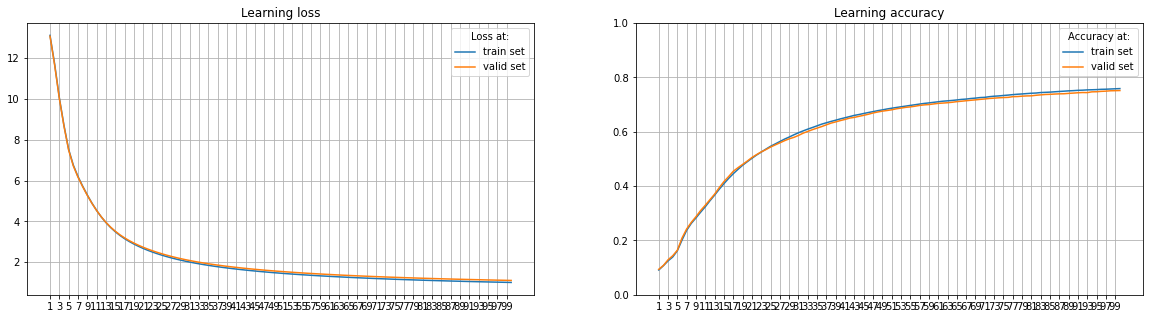

In [ ]:
epochs = 100           # число эпох 
training_steps = 1000  # сколько раз на эпохе теребить генератор батчей

# Вектора для метрик
loss_test, loss_train  = [ ], [ ] 
acc_test, acc_train = [ ], [ ]

for i in range(epochs):
    
    # Проходимся по всем батчам
    for batch_x, batch_y in train_data.take(training_steps):
        model_train(batch_x,batch_y)
        
        # Делаем щаг градиентного спуска 
        ### Ваш код для шага на текущем батче

        ########################
    
    # в конце эпохи считаем метрики
    p_train = logistic_regression(X_train)
    p_test = logistic_regression(X_test)
    
    loss_train.append(logloss(p_train, y_train))
    loss_test.append(logloss(p_test, y_test))
    
    acc_train.append(accuracy(p_train, y_train))
    acc_test.append(accuracy(p_test, y_test))
    
    # визуализируем
    visualize(loss_train, loss_test, acc_train, acc_test) 

Делать такие визуализации для больших нейронок и большого количества эпох не лучшая идея, но так как мы только учимся и хотим красивых картинок, то мы можем себе это позволить. __Отдельно обратите внимание,__ что TensorFlow очень чуствительна к размерностям. Например, чтобы работала функция `matmul`, нужно подать ей на вход обязательно матрицы. Даже если это матрица размера $1 \times 1$.

## Домашнее задание

Переделайте свою логистическую регрессию в двухслойную нейросетку. В качестве функции активации возьмите что угодно. Функцию, где будет реализована модель назовите `our_nn`.

In [ ]:
# Ваш код

Обучаем модель!

In [ ]:
epochs = 100           # число эпох 
training_steps = 1000  # сколько раз на эпохе теребить генератор батчей

# Вектора для метрик
loss_test, loss_train  = [ ], [ ] 
acc_test, acc_train = [ ], [ ]

for i in range(epochs):
    
    # Проходимся по всем батчам
    for batch_x, batch_y in train_data.take(training_steps):
        
        # Делаем щаг градиентного спуска 
        model_train(batch_x, batch_y)
    
    p_train = our_nn(X_train)
    p_test = our_nn(X_test)
    
    loss_train.append(logloss(p_train, y_train))
    loss_test.append(logloss(p_test, y_test))
    
    acc_train.append(accuracy(p_train, y_train))
    acc_test.append(accuracy(p_test, y_test))
    
    # визуализируем
    visualize(loss_train, loss_test, acc_train, acc_test) 

# Вместо итога.

__Но... Но... Но... Намного проще собрать это в Keras! Зачем нам страдать?__

Дело в том, что Keras лишь надстройка над tensorflow. По факту все слои, написанные для Keras - это замаскированный tensorflow. Более того, даже сетку, написанную на Keras можно обучать таким вот незатейливым циклом, как у нас. Иногда так намного проще проверять свои идеи. 

* Например, в прошлый раз мы с вами пытались мень скорость обучения сетки с помощью колбэков прямо в процессе обучения. Это было довольно неприятно и код был неочевидным. Если описывать процедуру обучения в виде цикла, работать становится проще.  В Tensorflow проще делать довольно много разных вещей, а также проще реализовывать и проверять какие-то свои идеи. 
* В том числе на Tensorflow можно писать новые слои для Keras и встраивать их в свои сетки. Этим мы тоже с вами позанимаемся.

## Бонусная инфа

Можно использовать keras, о котором мы поговорим на следующем семинаре, но и оставаться с большой степенью свободы Tensorflow, описывая модель почти как в pytorch (попроще, конечно, в торче все низкоуровнево)


In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.layers import BatchNormalization

In [ ]:
# создали объект с данными для обучения 
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# перемешали данные с окном в 5000 и сделали кучу батчей размера 512 
train_data = train_data.shuffle(5000).batch(512)

In [ ]:
#создаем класс с нашей моделью
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.d1 = Dense(64, activation='relu', kernel_initializer='he_normal')
        self.bn1 = BatchNormalization()
        self.d2 = Dense(64, activation='relu', kernel_initializer='he_normal')
        self.bn2 = BatchNormalization()
        self.d3 = Dense(10)

    def call(self, x, training=False):
        x = self.d1(x)
        x = self.bn1(x, training=training)
        x = self.d2(x)
        x = self.bn2(x, training=training)
        x = self.d3(x)
        return x

# Create an instance of the model
model = MyModel()

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [ ]:
@tf.function
def train_step(data, labels):
    with tf.GradientTape() as tape:
        predictions = model(data, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)

@tf.function
def test_step(data, labels):
    #не забываем про trainung=False
    predictions = model(data, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [ ]:
EPOCHS = 20

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for data_train, labels in train_data:
        train_step(data_train, labels)

    test_step(X_test, y_test)

    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result(): .4f}, '
        f'Accuracy: {train_accuracy.result() * 100: .4f}, '
        f'Test Loss: {test_loss.result(): .4f}, '
        f'Test Accuracy: {test_accuracy.result() * 100: .4f}'
    )

Epoch 1, Loss:  0.6651, Accuracy:  77.7167, Test Loss:  0.7042, Test Accuracy:  79.4600
Epoch 2, Loss:  0.4067, Accuracy:  85.7417, Test Loss:  0.4570, Test Accuracy:  84.4200
Epoch 3, Loss:  0.3602, Accuracy:  87.2167, Test Loss:  0.4160, Test Accuracy:  85.1900
Epoch 4, Loss:  0.3303, Accuracy:  88.1533, Test Loss:  0.4141, Test Accuracy:  84.6100
Epoch 5, Loss:  0.3088, Accuracy:  88.8550, Test Loss:  0.3896, Test Accuracy:  85.9300
Epoch 6, Loss:  0.2910, Accuracy:  89.3283, Test Loss:  0.3768, Test Accuracy:  86.4000
Epoch 7, Loss:  0.2793, Accuracy:  89.8150, Test Loss:  0.3926, Test Accuracy:  85.5800
Epoch 8, Loss:  0.2693, Accuracy:  90.0733, Test Loss:  0.3733, Test Accuracy:  86.6700
Epoch 9, Loss:  0.2560, Accuracy:  90.6783, Test Loss:  0.3786, Test Accuracy:  86.3400
Epoch 10, Loss:  0.2467, Accuracy:  90.9317, Test Loss:  0.3769, Test Accuracy:  86.0800
Epoch 11, Loss:  0.2384, Accuracy:  91.2817, Test Loss:  0.3523, Test Accuracy:  87.3200
Epoch 12, Loss:  0.2326, Accur